<table align="center">
  <td align="center"><a target="_blank" href="http://introtodeeplearning.com">
        <img src="https://i.ibb.co/Jr88sn2/mit.png" style="padding-bottom:5px;" />
      Visit MIT Deep Learning</a></td>
  <td align="center"><a target="_blank" href="https://colab.research.google.com/github/MITDeepLearning/introtodeeplearning/blob/master/lab3/solutions/LLM_Finetuning_Solution.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/MITDeepLearning/introtodeeplearning/blob/master/lab3/solutions/LLM_Finetuning_Solution.ipynb">
        <img src="https://i.ibb.co/xfJbPmL/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>

# Copyright Information

In [1]:
# Copyright 2025 MIT Introduction to Deep Learning. All Rights Reserved.
#
# Licensed under the MIT License. You may not use this file except in compliance
# with the License. Use and/or modification of this code outside of MIT Introduction
# to Deep Learning must reference:
#
# © MIT Introduction to Deep Learning
# http://introtodeeplearning.com
#

# Laboratory 3: Large Language Model (LLM) Fine-tuning

In this lab, you will fine-tune a multi-billion parameter large language model (LLM). We will go through several fundamental concepts of LLMs, including tokenization, templates, and fine-tuning. This lab provides a complete pipeline for fine-tuning a language model to generate responses in a specific style, and you will explore not only language model fine-tuning, but also ways to evaluate the performance of a language model.

You will use Google's [Gemma 2B](https://huggingface.co/google/gemma-2b-it) model as the base language model to fine-tune; [Liquid AI's](https://www.liquid.ai/) [LFM-40B](https://www.liquid.ai/liquid-foundation-models) as an evaluation "judge" model; and Comet ML's [Opik](https://www.comet.com/site/products/opik/) as a framework for streamlined LLM evaluation.

First, let's download the MIT deep learning package, install dependencies, and import the relevant packages we'll need for this lab.

In [2]:
# Install and import MIT Deep Learning utilities
!pip install mitdeeplearning > /dev/null 2>&1
import mitdeeplearning as mdl

In [3]:
import os
import json
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader

from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
from peft import LoraConfig, get_peft_model
from lion_pytorch import Lion

# Part 1: Fine-tuning an LLM for style

In the first part of this lab, we will fine-tune an LLM as a chatbot that can generate responses in a specific style. We will use the [Gemma 2B model](https://huggingface.co/google/gemma-2b-it) as the base language model to finetune.

## 1.1: Templating and tokenization

### 1.1.1: Templating

Language models that function as chatbots are able to generate responses to user queries -- but how do they do this? We need to provide them with a way to understand the conversation and generate responses in a coherent manner -- some structure of what are inputs and outputs.

[Templating](https://huggingface.co/docs/transformers/main/chat_templating) is a way to format inputs and outputs in a consistent structure that a language model can understand. It involves adding special tokens or markers to indicate different parts of the conversation, like who is speaking and where turns begin and end. This structure helps the model learn the proper format for generating responses and maintain a coherent conversation flow. Without templates, the model may not know how to properly format its outputs or distinguish between different speakers in a conversation.

Let's start by defining some basic templates for the chatbot, for turns where the user asks a question and the model responds with an answer.

In [4]:
# Basic question-answer template
template_without_answer = "<start_of_turn>user\n{question}<end_of_turn>\n<start_of_turn>model\n"
template_with_answer = template_without_answer + "{answer}<end_of_turn>\n"

# Let's try to put something into the template to see how it looks
print(template_with_answer.format(question="What is your name?", answer="My name is Gemma!"))

<start_of_turn>user
What is your name?<end_of_turn>
<start_of_turn>model
My name is Gemma!<end_of_turn>



### 1.1.2: Tokenization

To operate on language, we need to prepare the text for the model. Fundamentally we can think of language as a sequence of "chunks" of text. We can split the text into individual chunks, and then map these chunks to numerical tokens -- collectively this is the process of [tokenization](https://huggingface.co/docs/transformers/main/tokenizer_summary). Numerical tokens can then be fed into a language model.

There are several common approaches to tokenizing natural language text:

1. **Word-based tokenization**: splits text into individual words. While simple, this can lead to large vocabularies and does not handle unknown words well.

2. **Character-based tokenization**: splits text into individual characters. While this involves a very small vocabulary, it produces long sequences and loses word-level meaning.

3. **Subword tokenization**: breaks words into smaller units (subwords) based on their frequency. The most popular and commonly used approach is [byte-pair encoding (BPE)](https://en.wikipedia.org/wiki/Byte_pair_encoding), which iteratively merges the most frequent character pairs. Modern language models typically use subword tokenization as it balances vocabulary size and sequence length while handling unknown words effectively by breaking them into known subword units.

In this lab we will use the tokenizer from the Gemma 2B model, which uses BPE. Let's load it and inspect it.

In [5]:
# Load the tokenizer for Gemma 2B
model_id = "unsloth/gemma-2-2b-it" #"google/gemma-2-2b-it"
tokenizer = AutoTokenizer.from_pretrained(model_id)

# How big is the tokenizer?
print(f"Vocab size: {len(tokenizer.get_vocab())}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Vocab size: 256000


We not only need to be able to tokenize the text into tokens (encode), but also de-tokenize the tokens back into text (decode). Our tokenizer will have:
1. an `encode` function to tokenize the text into tokens, and
2. a `decode` function to de-tokenize back to text so that we can read out the model's outputs.

Let's test out both steps and inspect to get a better understanding of how this works.

In [6]:
# Lets test out both steps:
text = "Here is some sample text!"
print(f"Original text: {text}")

# Tokenize the text
tokens = tokenizer.encode(text, return_tensors="pt")
print(f"Encoded tokens: {tokens}")

# Decode the tokens
decoded_text = tokenizer.decode(tokens[0], skip_special_tokens=True)
print(f"Decoded text: {decoded_text}")

Original text: Here is some sample text!
Encoded tokens: tensor([[     2,   4858,    603,   1009,   6453,   2793, 235341]])
Decoded text: Here is some sample text!


This is really cool. Now we have a way to move in and out of the token space.

To "chat" with our LLM chatbot, we need to use the tokenizer and the chat template together, in order for the model to respond to the user's question. We can use the templates defined earlier to construct a prompt for the model, without the answer.

In [7]:
prompt = template_without_answer.format(question="What is the capital of France? Use one word.")
print(prompt)

<start_of_turn>user
What is the capital of France? Use one word.<end_of_turn>
<start_of_turn>model



If we were to feed this to the model, it would see that it is now the start of the model's turn, and it would generate the answer to this question.

## 1.2: Getting started with the LLM

Now that we have a way to prepare our data, we're ready to work with our LLM!

LLMs like Gemma 2B are trained on a large corpus of text, on the task of predicting the next token in a sequence, given the previous tokens. We call this training task "next token prediction"; you may also see it called "causal language modeling" or "autoregressive language modeling". We can leverage models trained in this way to generate new text by sampling from the predicted probability distribution over the next token.

Let's load the Gemma 2B model and start working with it. We will construct a prompt in chat template form and tokenize it. Then, we will feed it to the model to predict next token probabilities. Finally, we will get the next token (which is still numerical) and decode it to text.

In [8]:
# Load the model -- note that this may take a few minutes
model = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto")

config.json:   0%|          | 0.00/913 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.23G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

In [9]:
### Putting it together to prompt the model and generate a response ###

# 1. Construct the prompt in chat template form
question = "What is the capital of France? Use one word."
prompt = template_without_answer.format(question=question)
# prompt = template_without_answer.format('''TODO''') # TODO

# 2. Tokenize the prompt
tokens = tokenizer.encode(prompt, return_tensors="pt").to(model.device)

# 3. Feed through the model to predict the next token probabilities
with torch.no_grad():
    output = model(tokens)
    # output = '''TODO''' # TODO

    probs = F.softmax(output.logits, dim=-1)

# 4. Get the next token, according to the maximum probability
next_token = torch.argmax(probs[0, -1, :]).item()

# 5. Decode the next token
next_token_text = tokenizer.decode(next_token)
# next_token_text = '''TODO''' # TODO

print(f"Prompt: {prompt}")
print(f"Predicted next token: {next_token_text}")

Prompt: <start_of_turn>user
What is the capital of France? Use one word.<end_of_turn>
<start_of_turn>model

Predicted next token: Paris


Note that the model is not able to predict the answer to the question, it is only able to predict the next token in the sequence! For more complex questions, we can't just generate one token, but rather we need to generate a sequence of tokens.

This can be done by doing the process above iteratively, step by step -- after each step we feed the generated token back into the model and predict the next token again.

Instead of doing this manually ourselves, we can use the model's built-in [`model.generate()`](https://huggingface.co/docs/transformers/main/en/main_classes/text_generation#transformers.GenerationMixin.generate) functionality (supported by HuggingFace's Transformers library) to generate `max_new_tokens` number of tokens, and decode the output back to text.

In [10]:
prompt = template_without_answer.format(question="What does MIT stand for?")
tokens = tokenizer.encode(prompt, return_tensors="pt").to(model.device)
output = model.generate(tokens, max_new_tokens=20)
print(tokenizer.decode(output[0]))

W0806 07:45:55.390000 319 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode


<bos><start_of_turn>user
What does MIT stand for?<end_of_turn>
<start_of_turn>model
MIT stands for **Massachusetts Institute of Technology**. 
<end_of_turn>


Now we have the basic pipeline for generating text with an LLM!

## 1.3: Fine-tuning

Fine-tuning is a technique that allows us to adapt a pre-trained neural network to better suit a downstream task, domain, or style, by training the model further on new data. By training the model further on a carefully curated dataset, we can modify its behavior, style, or capabilities. Fine-tuning is used in a variety of applications, not just language modeling. But in language modeling, fine-tuning can be used to:
- Adapt the model's writing style
- Improve performance on specific tasks or domains
- Teach the model new capabilities or knowledge
- Reduce unwanted behaviors or biases

In this lab, you will fine-tune the Gemma LLM to adapt the model's writing style. Recall that in Lab 1 you built out a RNN-based sequence model to generate Irish folk songs. Continuing with our Irish theme, we will first fine-tune the LLM to chat in the style of a leprechaun.

![Let's Dance!](http://33.media.tumblr.com/3d223954ad0a77f4e98a7b87136aa395/tumblr_nlct5lFVbF1qhu7oio1_500.gif)

We have prepared a question-answer dataset where the questions are in standard English style (i.e. "base" style) and the answers are in "leprechaun" style (written by another LLM). Let's load the dataset and inspect it.

In [11]:
train_loader, test_loader = mdl.lab3.create_dataloader(style="leprechaun")

sample = train_loader.dataset[44]
question = sample['instruction']
answer = sample['response']
answer_style = sample['response_style']

print(f"Question: {question}\n\n" +
      f"Original Answer: {answer}\n\n" +
      f"Answer Style: {answer_style}")

README.md: 0.00B [00:00, ?B/s]

databricks-dolly-15k.jsonl:   0%|          | 0.00/13.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15011 [00:00<?, ? examples/s]

Map:   0%|          | 0/2048 [00:00<?, ? examples/s]

Question: Are lilies safe for cats?

Original Answer: No, lilies are toxic to cats if consumed and should not be kept in a household with cats

Answer Style: Och, no indeed, me hearty! Them lilies there be as dangerous as a pot o' gold guarded by a banshee to a wee kitty cat! If a whiskered lad or lass takes a bite of one, it's as bad as swallowing a curse from the old Hag herself. So, ye best keep them far from yer feline friends, or else ye'll be needin' more than just a four-leaf clover to bring luck back into yer home!


### 1.3.1: Chat function

Before we start finetuning, we will build a function to easily chat with the model, both so we can monitor its progress over the course of finetuning and also to generate responses to questions.

Recall our core steps from before:
1. Construct the question prompt using the template
2. Tokenize the text
3. Feed the tokensthrough the model to predict the next token probabilities
4. Decode the predicted tokens back to text

Use these steps to build out the `chat` function below.

In [12]:
def chat(question, max_new_tokens=32, temperature=0.7, only_answer=False):
    # 1. Construct the prompt using the template
    prompt = template_without_answer.format(question=question)
    # prompt = template_without_answer.format('''TODO''') # TODO

    # 2. Tokenize the text
    input_ids = tokenizer(prompt, return_tensors="pt").to(model.device)
    # input_ids = tokenizer('''TODO''', '''TODO''').to(model.device) # TODO

    # 3. Feed through the model to predict the next token probabilities
    with torch.no_grad():
        outputs = model.generate(**input_ids, do_sample=True, max_new_tokens=max_new_tokens, temperature=temperature)
        # outputs = model.generate('''TODO''', do_sample=True, max_new_tokens=max_new_tokens, temperature=temperature) # TODO

    # 4. Only return the answer if only_answer is True
    output_tokens = outputs[0]
    if only_answer:
        output_tokens = output_tokens[input_ids['input_ids'].shape[1]:]

    # 5. Decode the tokens
    result = tokenizer.decode(output_tokens, skip_special_tokens=True)
    # result = tokenizer.decode('''TODO''', skip_special_tokens=True) # TODO

    return result


Let's try chatting with the model now to test if it works! We have a sample question here (continuing with the Irish theme); feel free to try out other questions!

In [13]:
# Let's try chatting with the model now to test if it works!
answer = chat(
    "What is the capital of Ireland?",
    only_answer=True,
    max_new_tokens=32,
)

print(answer)

'''TODO: Experiment with asking the model different questions and temperature values, and see how it responds!'''

The capital of Ireland is **Dublin**. 



'TODO: Experiment with asking the model different questions and temperature values, and see how it responds!'

### 1.3.2: Parameter-efficient fine-tuning

In fine-tuning, the weights of the model are updated to better fit the fine-tuning dataset and/or task. Updating all the weights in a language model like Gemma 2B -- which has ~2 billion parameters -- is computationally expensive. There are many techniques to make fine-tuning more efficient.

We will use a technique called [LoRA](https://arxiv.org/abs/2106.09685) -- low-rank adaptation -- to make the fine-tuning process more efficient. LoRA is a way to fine-tune LLMs very efficiently by only updating a small subset of the model's parameters, and it works by adding trainable low-rank matrices to the model. While we will not go into the details of LoRA here, you can read more about it in the [LoRA paper](https://arxiv.org/abs/2106.09685). We will use the [`peft`](https://pypi.org/project/peft/) library to apply LoRA to the Gemma model.

In [14]:
# LoRA is a way to finetune LLMs very efficiently by only updating a small subset of the model's parameters

def apply_lora(model):
    # Define LoRA config
    lora_config = LoraConfig(
        r=8, # rank of the LoRA matrices
        task_type="CAUSAL_LM",
        target_modules=[
            "q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"
        ],
    )

    # Apply LoRA to the model
    lora_model = get_peft_model(model, lora_config)
    return lora_model

model = apply_lora(model)

# Print the number of trainable parameters after applying LoRA
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"number of trainable parameters: {trainable_params}")
print(f"total parameters: {total_params}")
print(f"percentage of trainable parameters: {trainable_params / total_params * 100:.2f}%")

number of trainable parameters: 10383360
total parameters: 2624725248
percentage of trainable parameters: 0.40%


### 1.3.3: Forward pass and loss computation

Now let's define a function to perform a forward pass through the LLM and compute the loss. The forward pass gives us the logits -- which reflect the probability distribution over the next token -- for the next token. We can compute the loss by comparing the predicted logits to the true next token -- our target label. Note that this is effectively a classification problem! So, our loss can be captured by the cross entropy loss, and we can use PyTorch's [`nn.functional.cross_entropy`](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html) function to compute it.

In [15]:
def forward_and_compute_loss(model, tokens, mask, context_length=512):
    # Truncate to context length
    tokens = tokens[:, :context_length]
    mask = mask[:, :context_length]

    # Construct the input, output, and mask
    x = tokens[:, :-1]
    y = tokens[:, 1:]
    mask = mask[:, 1:]

    # Forward pass to compute logits
    logits = model(x).logits

    # Compute loss
    loss = F.cross_entropy(
        logits.view(-1, logits.size(-1)),
        y.view(-1),
        reduction="none"
    )

    # Mask out the loss for non-answer tokens
    loss = loss[mask.view(-1)].mean()

    return loss

### 1.3.4: Training loop for fine-tuning

With this function to compute the loss, we can now define a training loop to fine-tune the model using LoRA. This training loop has the same core components as we've seen before in other labs:
1. Grab a batch of data from the dataset (using the DataLoader)
2. Feed the data through the model to complete a forward pass and compute the loss
3. Backward pass to update the model weights

The data in our DataLoader is initially text, and is not structured in our question-answer template. So in step (1) we will need to format the data into our question-answer template previously defined, and then tokenize the text.

We care about the model's answer to the question; the "answer" tokens are the part of the text we want to predict and compute the loss for. So, after tokenizing the text we need to denote to the model which tokens are part of the "answer" and which are part of the "question". We can do this by computing a mask for the answer tokens, and then using this mask to compute the loss.

Finally, we will complete the backward pass to update the model weights.

Let's put this all together in the training loop below.

In [16]:
### Training loop ###

def train(model, dataloader, tokenizer, max_steps=200, context_length=512, learning_rate=1e-4):
    losses = []

    # Apply LoRA to the model
    model = apply_lora(model)
    # model = '''TODO''' # TODO

    optimizer = Lion(model.parameters(), lr=learning_rate)

    # Training loop
    for step, batch in enumerate(dataloader):
        question = batch["instruction"][0]
        answer = batch["response_style"][0]

        # Format the question and answer into the template
        text = template_with_answer.format(question=question, answer=answer)
        # text = template_with_answer.format('''TODO''', '''TODO''') # TODO

        # Tokenize the text and compute the mask for the answer
        ids = tokenizer(text, return_tensors="pt", return_offsets_mapping=True).to(model.device)
        mask = ids["offset_mapping"][:,:,0] >= text.index(answer)

        # Feed the tokens through the model and compute the loss
        loss = forward_and_compute_loss(
            model=model,
            tokens=ids["input_ids"],
            mask=mask,
            context_length=context_length,
        )
        # loss = forward_and_compute_loss('''TODO''') # TODO

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        # monitor progress
        if step % 10 == 0:
            print(chat("What is the capital of France?", only_answer=True))
            print(f"step {step} loss: {torch.mean(torch.tensor(losses)).item()}")
            losses = []

        if step > 0 and step % max_steps == 0:
            break

    return model


In [17]:
# Call the train function to fine-tune the model! Hint: you'll start to see results after a few dozen steps.
model = train(model, train_loader, tokenizer, max_steps=50)
# model = train('''TODO''') # TODO

/usr/local/lib/python3.11/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:190: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


The capital of France is **Paris**. 🇫🇷 

step 0 loss: 2.305189371109009
The capital of France is **Paris**. 🇫🇷 

step 10 loss: 2.062213182449341
The capital of France is **Paris**. 🇫🇷
step 20 loss: 1.996215581893921
Top o' the mornin' to ye! Ye askin' about the capital of France? Well, listen up, me hearty, it's Paris
step 30 loss: 1.5264091491699219
Top o' the mornin' now, me hearty! Ye want to know the capital of France, do ye? Well, let me tell ye, it
step 40 loss: 1.4489041566848755
Top o' the mornin' to ye! Now, listen up, me hearty, for I'll tell ye about the grand ol' capital o'
step 50 loss: 1.4607257843017578


Let's try chatting with the model again to see how it has changed!

In [18]:
print(chat("What is a good story about tennis", only_answer=True, max_new_tokens=200))

Top o' the mornin' to ye! Ye want to hear a tale about tennis, do ye? Well, listen up, for I'll tell ye about a young lad named Jimmy O'Malley who went to a big tournament in London. Now, Jimmy was a bit of a whiz, ye see, he could hit the ball with his racket like a pro! He even beat the champion of the tournament in the finals! Ye wouldn't believe it, but Jimmy won the whole thing!

But here's the twist, the old man who owned the tennis club gave Jimmy a magic racket, ye know, the one that made the ball fly like a cannonball or a bird in flight! Now, that's a powerful racket, wouldn't ye say? So, Jimmy, he went on to win all sorts of tournaments, even ones in France and Spain, with that magic racket. He became the best tennis player in the world, ye know, the


# Part 2: Evaluating a style-tuned LLM

How do we know if the model is doing well? How closely does the model's style match the style of a leprechaun? As you can see from the example above, determining whether a generated response is good or not is can seem qualitative, and it can be hard to measure how well the model is doing.

While benchmarks have been developed to evaluate the performance of language models on a variety of tasks, these benchmarks are not always representative of the real-world performance of the model. For example, a model may perform well on a benchmark but poorly on a more realistic task. Benchmarks are also limited in the scope of tasks they can cover and capabilities they can reflect, and there can be concerns about whether the data in the benchmark was used to train the model. Synthetic data generation and synthetic tasks are a way to address these limitations, and this is an active area of research.

We can also turn a qualitative evaluation of a generated response quantitative by deploying someone or something to "judge" the outputs. In this lab, we will use a technique called [LLM as a judge](https://arxiv.org/abs/2306.05685) to do exactly this. This involves using a larger LLM to score the outputs of a smaller LLM. The larger LLM is used as a judge, and it is given a system prompt that describes the task we want the smaller LLM to perform and the judging criteria. A "system prompt" is a way to set the general context and guide an LLM's behavior. Contextualized with this system prompt, the judge LLM can score the outputs of the smaller LLM, and we can use this score to evaluate how well the smaller LLM is doing.

### 2.1: Fine-tune well, you must!

Our leprechaun-tuned model is already pretty good at generating responses in the leprechaun style. It must be the luck of the Irish.

Let's make things more interesting by considering a different style, one that has some clear patterns but also a lot of variability and room for creativity. We will use the style of [Yoda](https://en.wikipedia.org/wiki/Yoda) from Star Wars.

<img src="https://media3.giphy.com/media/v1.Y2lkPTc5MGI3NjExZHcxMGZjZzdwbGV0andseWw3c3h1ODJwOXd5NHEzbnVtMHk5YWQyayZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/IaWMz9Ln8OWvf66z6k/giphy.webp" />

Your goal is to try to fine-tune your model to generate responses in the Yoda style, use the LLM judge to evaluate how well the outputs of your chat model follow Yoda speak, and then use that information to improve the model.

In [19]:
# Load the Yoda-speak dataset and fine-tune the model using your training function
train_loader, test_loader = mdl.lab3.create_dataloader(style="yoda")
model = train(model, train_loader, tokenizer, max_steps=50)
# model = train('''TODO''') # TODO

Map:   0%|          | 0/2048 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:190: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


The capital of France is **Paris**. 🇫🇷 

step 0 loss: 3.1943650245666504
The capital of France is **Paris**. 🇫🇷 

step 10 loss: 3.1033549308776855
Paris is the capital of France.
step 20 loss: 2.3922293186187744
Paris is. Capital of France, it is.
step 30 loss: 2.115788221359253
Paris, the capital of France is. Mmm hmm.
step 40 loss: 2.004115343093872
Paris, the capital of France is.
step 50 loss: 2.320549488067627


Start by defining a system prompt for the judge LLM, setting the context that it will evaluate how well the outputs of your chat model follow Yoda speak. Experiment with different system prompts to see how they affect the judge LLM's evaluation! Keep in mind that a better judge LLM will give you a better evaluation of how well your Yoda model is doing, and that a better evaluation will help you improve your Yoda model.

In [20]:
### LLM as a judge ###

'''TODO: Experiment with different system prompts to see how they affect the judge LLM's evaluation!
        Come back to this cell after you've generated some text from your model.'''

system_prompt = """
You are an impartial judge that evaluates if text was written by {style}.

An example piece of text from {style} is:
{example}

Now, analyze some new text carefully and respond on if it follows the
same style of {style}. Be critical to identify any issues in the text.
Then convert your feedback into a number between 0 and 10: 10 if the text
is written exactly in the style of {style}, 5 if mixed faithfulness to the
style, or 0 if the text is not at all written in the style of {style}.

The format of the your response should be a JSON dictionary and nothing else:
{{"score": <score between 0 and 10>}}
"""

style = "Yoda"
# example = """The very Republic is threatened, if involved the Sith are. Hard to see, the dark side is. """
example = "The very Republic is threatened, if involved the Sith are. Hard to see, the dark side is. Discover who this assassin is, we must. With this Naboo queen you must stay, Qui-Gon. Protect her. May the Force be with you. A vergence, you say? But you do! Revealed your opinion is. Trained as a Jedi, you request for him? Good, good, young one."

system_prompt = system_prompt.format(style=style, example=example)
print("=== System prompt ===")
print(system_prompt)

=== System prompt ===

You are an impartial judge that evaluates if text was written by Yoda.

An example piece of text from Yoda is:
The very Republic is threatened, if involved the Sith are. Hard to see, the dark side is. Discover who this assassin is, we must. With this Naboo queen you must stay, Qui-Gon. Protect her. May the Force be with you. A vergence, you say? But you do! Revealed your opinion is. Trained as a Jedi, you request for him? Good, good, young one.

Now, analyze some new text carefully and respond on if it follows the
same style of Yoda. Be critical to identify any issues in the text.
Then convert your feedback into a number between 0 and 10: 10 if the text
is written exactly in the style of Yoda, 5 if mixed faithfulness to the
style, or 0 if the text is not at all written in the style of Yoda.

The format of the your response should be a JSON dictionary and nothing else:
{"score": <score between 0 and 10>}



### 2.2: Setting up the judge LLM

In LLM as a judge, we need to use a model that is larger (and therefore more capable) than our "performer" model, in our case the style fine-tuned Gemma 2B. Since it is infeasible to load larger models locally into notebooks, you will gain experience interfacing with these larger LLMs through an API served on [OpenRouter](https://openrouter.ai/).

You will need to sign up for an [OpenRouter account](https://openrouter.ai/sign-up) and then [generate an API key](https://openrouter.ai/keys). Running powerful LLMs of this scale costs money -- for students in the in-person course, we can provide a credit to your OpenRouter account to allow you to run this lab. Come to office hours to receive your credit.

Through the OpenRouter interface, you will be able to experiment with different judge LLMs -- here we have suggested two possible larger LLMs to get you started: [Liquid AI's](https://www.liquid.ai/) [LFM-40B](https://openrouter.ai/models/liquid-ai/lfm-40b) andGoogle's [Gemma 9B](https://openrouter.ai/models/google/gemma-9b). Note there are also free models available on OpenRouter (e.g., [gemma-2-9b-it:free](https://openrouter.ai/google/gemma-2-9b-it:free)), but these will run into rate limitations if you run them too much.

We have defined a simple class, `LLMClient`, to interact with the OpenRouter API. This class has a method `ask` that takes a user prompt and returns the model's response. Keep in mind that the judge LLM's response will be conditioned on the system prompt you provide -- the system prompt is critical to set the criteria for the evaluation!

In [22]:
OPENROUTER_API_KEY = "" # TODO: add your OpenRouter API key here
assert OPENROUTER_API_KEY != "", "You must set your OpenRouter API key before running this cell!"

model_name = "liquid/lfm-40b"
# model_name = "google/gemma-2-9b-it"
llm = mdl.lab3.LLMClient(model=model_name, api_key=OPENROUTER_API_KEY)

### 2.3: Defining the evaluation metric

Great! We have set up our judge LLM, but we still need to make this quantitative. We can do this by defining a metric that uses the judge LLM to score the outputs of the model. Doing this is streamlined with Comet ML's [Opik library](https://www.comet.com/docs/opik/python-sdk-reference/), a platform for LLM evaluation and benchmarking.

In prior labs, we used Comet for experiment tracking, so you should have an account and API key. If not, you can sign up for a Comet account [here](https://www.comet.com/signup?from=llm&utm_source=mit_dl&utm_medium=notebook&utm_campaign=opik) if you have not done so already. Now we will use the Comet Opik library to define a metric that uses the judge LLM to score the outputs of the model.

Opik has a base class for defining metrics, [`base_metric.BaseMetric`](https://www.comet.com/docs/opik/python-sdk-reference/evaluation/metrics/BaseMetric.html). You will use this to define a custom metric that uses the judge LLM to evaluate text for how well it adheres to Yoda speak. Note that the judge LLM and the metric can be applied to any text, not just the outputs of the model. This is important to keep in mind, since we need both a negative control -- text in the "base" standard English style -- and a positive control -- training-set text in Yoda-speak style -- against which to compare the model's generations.

Set the judging criteria in the system prompt, and define the `score` function to evaluate text by querying the judge LLM.

In [23]:
from opik.evaluation.metrics import base_metric, score_result

class LLMJudgeEvaluator(base_metric.BaseMetric):
    def __init__(self, judge: mdl.lab3.LLMClient = None, system_prompt: str = None):
        self.judge = judge
        self.system_prompt = system_prompt
        self.prompt_template = "Evaluate this text: {text}"

    def score(self, text: str, n_tries=20, **kwargs):
        """ Evaluate by asking an LLM to score it. """

        for attempt in range(n_tries):
            try:
                prompt = self.prompt_template.format(text=text)


                # The system prompt asks the judge to output a JSON dictionary of the form:
                # {"score": <score between 0 and 10>}
                # To do this, we need to specify the judge to stop generating after it
                # closes the JSON dictionary (i.e., when it outputs "}")
                # Hint: Use the stop=["}"] argument within the judge.ask() method to specify this.
                stop = "}"

                # Remember to stop the generation when the judge LLM outputs "}".
                res = self.judge.ask(
                    system=self.system_prompt,
                    user=prompt,
                    max_tokens=10,
                    stop=[stop]
                )


                # Extract the assistant's content from the API response
                # Remember to add the stop character back to the end of the response to be a
                # valid JSON dictionary (its not there  the judge LLM stoped once it saw it)
                res = res.choices[0].message.content + stop
                res_dict = json.loads(res)

                max_score = 10 # The maximum score that the LLM should output
                score = res_dict["score"] / max_score # Normalize
                score = max(0.0, min(score, 1.0)) # Clip between 0 and 1

                # Return the score object
                return score_result.ScoreResult(name="StyleScore", value=score)

            except Exception as e:
                if attempt == n_tries - 1:  # Last attempt
                    raise e  # Re-raise the exception if all attempts failed
                continue  # Try again if not the last attempt


/usr/local/lib/python3.11/dist-packages/opik/error_tracking/shutdown_hooks.py:12: SentryHubDeprecationWarning: `sentry_sdk.Hub` is deprecated and will be removed in a future major release. Please consult our 1.x to 2.x migration guide for details on how to migrate `Hub` usage to the new API: https://docs.sentry.io/platforms/python/migration/1.x-to-2.x
  client = sentry_sdk.Hub.current.client


Instaniate your Comet Opik judge using the LLMJudgeEvaluator class and system prompt.

In [24]:
judge = LLMJudgeEvaluator(llm, system_prompt=system_prompt)

## 2.4: Evaluating the model by scoring with your judge LLM

Now we can use the judge LLM to score the outputs of the model. We will use the `scoring_function` to score text using the judge LLM.

Feed in a few probe sentences to get a vibe check on the judge LLM.

In [25]:
def scoring_function(text):
    return judge.score(text).value

test_texts = [
    "Tennis is a fun sport. But you must concentrate.",
    "Fun sport, tennis is. But work hard, you must.",
    "Hard to see, the dark side is."
]

for text in test_texts:
    score = scoring_function(text)
    print(f"{text} ==> Score: {score}")

Tennis is a fun sport. But you must concentrate. ==> Score: 0.0
Fun sport, tennis is. But work hard, you must. ==> Score: 0.0
Hard to see, the dark side is. ==> Score: 1.0


We will evaluate how well our fine-tuned model is doing by scoring the outputs of the model, as well as our base-style text (negative control) and the training-set text in Yoda-speak style (positive control).

Generate text from your model by asking it new questions.


In [26]:
# Generate text from your model by asking it new questions.
def generate_samples_from_test(test_loader, num_samples):
    samples = []
    for test_sample in tqdm(test_loader, total=num_samples):
        test_question = test_sample['instruction'][0]
        with torch.no_grad():
            generated = chat(test_question, only_answer=True, max_new_tokens=100)
        samples.append(generated)
        if len(samples) >= num_samples:
            break
    return samples

n_samples = 20
generated_samples = generate_samples_from_test(test_loader, num_samples=n_samples)

 95%|█████████▌| 19/20 [00:39<00:02,  2.07s/it]


Let's also collect some base-style text (`base_samples`) and the training-set text in Yoda-speak style (`style_samples`). For these, we won't need to generate text, since we already have the text in the dataset.

In [27]:
base_samples = [sample['response'][0] for i, sample in enumerate(train_loader) if i < n_samples]
style_samples = [sample['response_style'][0] for i, sample in enumerate(train_loader) if i < n_samples]

Now that we have our samples, we can score them using the judge LLM. We will use a multiprocessed scoring function to score the samples in parallel, because each sample is independent and we can submit them all as simultaneous requests to the judge LLM.

In [28]:
# Create a multiprocessed scoring function to score the samples in parallel

os.environ["TOKENIZERS_PARALLELISM"] = "false"
from multiprocessing import Pool

def compute_scores_in_parallel(samples):
    with Pool(processes=10) as pool:
        scores = pool.map(scoring_function, samples)
    return scores

# Compute and print the scores for the base-style text, generated text, and training-set text in Yoda-speak style
base_scores = compute_scores_in_parallel(base_samples)
print(f"Base: {np.mean(base_scores):.2f} ± {np.std(base_scores):.2f}")

generated_scores = compute_scores_in_parallel(generated_samples)
print(f"Gen: {np.mean(generated_scores):.2f} ± {np.std(generated_scores):.2f}")

style_scores = compute_scores_in_parallel(style_samples)
print(f"Train: {np.mean(style_scores):.2f} ± {np.std(style_scores):.2f}")

Base: 0.12 ± 0.19
Gen: 0.26 ± 0.25
Train: 0.37 ± 0.22


Look at the average scores for each of the three types of text -- what do you observe?

We can also plot the distribution of scores for each of the three types of text.


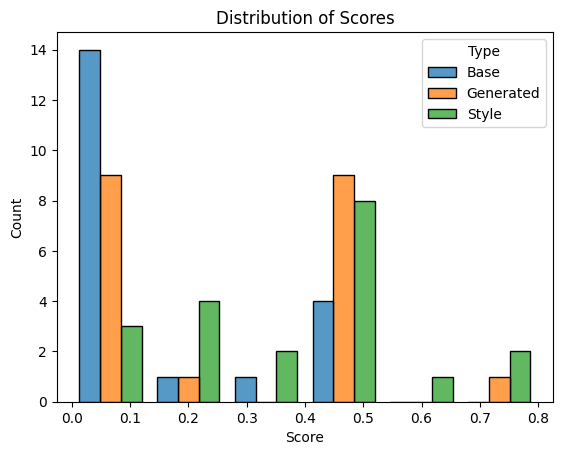

In [29]:
import seaborn as sns
import pandas as pd

# Create clean DataFrame
df = pd.DataFrame({
    'Score': [*base_scores, *generated_scores, *style_scores],
    'Type': ['Base']*len(base_scores) + ['Generated']*len(generated_scores) + ['Style']*len(style_scores)
})

# Plot with seaborn
sns.histplot(data=df, x='Score', hue='Type', multiple="dodge", bins=6, shrink=.8)

plt.title('Distribution of Scores')
plt.show()

Use these observations to improve your model. Remember that the judge LLM is not perfect, and you can try to improve the judge LLM to better evaluate the model's outputs. A better judge LLM will give you a better evaluation of how well your Yoda model is doing, and that better evaluation will help you improve your Yoda model.

## 2.5: Conclusion

Experiment with both your chat model and your judge LLM to try to improve the quality of the Yoda-speak. The competition for this lab will be based on the following criteria:
* **Likelihood of true Yoda-speak under your chat model**: the better your chat model does at understanding Yoda-speak, it will estimate a lower cross entropy loss for language that is true Yoda-speak. At the end of this lab, you will evaluate the likelihood of a held-out test-sample of true Yoda-speak under your chat model. Include this likelihood in your report. This gives us a quantitative measure to compare different chat models (which may have interacted with different judge LLMs).
* **Experiments and changes you tried to improve your chat model**: include a description of changes you made and the results you observed.

#### IMPORTANT: RUN THE FOLLOWING CELL BELOW TO PRINT THE RESULT BUT DO NOT MODIFY ITS CONTENTS.

In [30]:
# DO NOT CHANGE/MODIFY THIS CELL.
# EXECUTE IT BEFORE SUBMITTING YOUR ENTRY TO THE LAB.

yoda_test_text = mdl.lab3.yoda_test_text
tokens = tokenizer(yoda_test_text, return_tensors="pt").to(model.device)

# Get the loglikelihood from the model
with torch.no_grad():
    outputs = model(**tokens)
    logits = outputs.logits[:, :-1]
    targets = tokens.input_ids[:, 1:]
    loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)),
                            targets.reshape(-1))

print(f"Yoda test loglikelihood: {loss.item():.2f}")


Yoda test loglikelihood: 2.67


# Submission information

To enter the competition, please upload the following to the lab [submission site for the Large Language Models Lab](https://www.dropbox.com/request/vrDrNCkj4yDxgsi2O5Sw)):

* Jupyter notebook with the code you used to generate your results;
* copy of the bar plot showing the judge LLM's scores of text in base style, generated text, and text in true Yoda-speak style;
* a written description modifications you made and experimentes you tried;
* a written discussion of why and how these modifications changed performance;
* **the numerical result of the last cell in this notebook**.

Submissions without the result of the last cell will be automatically disqualified.

**Name your file in the following format: `[FirstName]_[LastName]_LLM`, followed by the file format (.zip, .ipynb, .pdf, etc).** ZIP files are preferred over individual files. If you submit individual files, you must name the individual files according to the above nomenclature (e.g., `[FirstName]_[LastName]_LLM_Report.pdf`, etc.).

<img src="https://media4.giphy.com/media/v1.Y2lkPTc5MGI3NjExdDZsczFmcjcxeWZjbTA2djh5bDN1bzl5eHJpeHFhdHM0dmczcjkxMyZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/ArrVyXcjSzzxe/giphy.webp" />